## **README**
 
IGNORE LOSS WRT STYLE CODE. BUT KEEP KL LOSS FOR CONTENT CODE? 

[GVAE] H. Hosoya, “Group-based Learning of Disentangled Representations with Generalizability for Novel Contents,” in Proceedings of the Twenty-Eighth International Joint Conference on Artificial Intelligence, Macao, China, 2019, pp. 2506–2513, doi: 10.24963/ijcai.2019/348.

 
[MLVAE] D. Bouchacourt, R. Tomioka, and S. Nowozin, “Multi-Level Variational Autoencoder: Learning Disentangled Representations from Grouped Observations,” arXiv:1705.08841 [cs, stat], May 2017, Accessed: Feb. 19, 2021. [Online]. Available: http://arxiv.org/abs/1705.08841.
  

In [1]:
# -*- coding: utf-8 -*-
from IPython import display

import os, sys, time, glob, io, pprint, re, shutil
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import h5py
import pandas as pd
from datetime import datetime

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
tfkltd = tf.keras.layers.TimeDistributed
from tensorflow.keras.utils import to_categorical

from absl import app, flags

if not sys.version_info[0]==3:
    sys.exit("Python 3 required")

""" specify available GPUs """
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

""" limit GPU memory growth """
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # currently memory growth needs to be same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs\n\n")
    except RuntimeError as e:
        # memory growth must be set before GPUs have been initialized
        print(e)
        
""" clear tensorflow session """
tfk.backend.clear_session()


4 Physical GPUs 4 Logical GPUs




In [2]:
strategy = tf.distribute.MirroredStrategy()
print('num devices = %d'%strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
num devices = 4


### Bag MNIST data into instances

In [3]:
NUM_INSTANCES = 21 # number of instances in a bag
NUM_CLASS = 10     # mnist has 10 classes

(trn_images, trn_labels), (tst_images, tst_labels) = tfk.datasets.mnist.load_data()

def rescale_and_flatten_images(images):
    images = images.reshape((images.shape[0], 28*28)) / 255.
    return images.astype('float32')
#     return np.where(images > .5, 1.0, 0.0).astype('float32')

trn_images = rescale_and_flatten_images(trn_images)
tst_images = rescale_and_flatten_images(tst_images)

print(trn_images.shape)
print(tst_images.shape)

(60000, 784)
(10000, 784)


In [4]:
BUFFER_SIZE = trn_images.shape[0]
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

NUM_TRAIN=trn_images.shape[0]
MASK_SIZE=10

class MaskedMNISTDataset(tf.data.Dataset):
    def _generator():
        """ Yields a single datapoint which consists of the tuple

            data_replicate = (R[0]data, ..., R[nreplicate]data)
            shifts = 
        """
        for ii in range(NUM_TRAIN):
            img = trn_images[ii,:] # [data_dim]
            img = np.expand_dims(img, axis=0) #[1, data_dim]
            img_instances = np.repeat(img, NUM_INSTANCES, axis=0) #[instances, data_dim]
            
            for kk in range(NUM_INSTANCES):
                tmp = img_instances[kk,:].reshape(28,28)

                mask = np.ones((28,28))
                xx = np.random.randint(28-MASK_SIZE)
                yy = np.random.randint(28-MASK_SIZE)
                
                tmp[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 1.
                img_instances[kk,:] = tmp.flatten()
            
            bagged_masked_img = img_instances
            
#             mask_instances = np.zeros(img_instances.shape)
#             for kk in range(NUM_INSTANCES):
#                 mask = np.ones((28,28))
#                 xx = np.random.randint(28-MASK_SIZE)
#                 yy = np.random.randint(28-MASK_SIZE)
                
#                 mask[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 0.
#                 mask_instances[kk,:] = mask.flatten()
            
#             bagged_masked_img = img_instances*mask_instances
            
            yield bagged_masked_img.astype('float32')
               
    def __new__(self):
        return tf.data.Dataset.from_generator(
            self._generator,
            output_types = (tf.float32),
            output_shapes = (tf.TensorShape([NUM_INSTANCES, 28*28])),            
        )
    
trn_dataset = MaskedMNISTDataset().prefetch(tf.data.experimental.AUTOTUNE)
trn_dataset = trn_dataset.shuffle(NUM_TRAIN)
trn_dataset = trn_dataset.batch(GLOBAL_BATCH_SIZE)

# distributed dataset
trn_dist_dataset = strategy.experimental_distribute_dataset(trn_dataset)

### Define GVAE Model

In [5]:
""" Custom Layers """
class StyleEncoder(tfkl.Layer):
    """ Responsible for encoding the style of each instance.
    
    Maps [?, instances, data_dim] -> [?, instances, sty_dim] (for mean and log-variance)
    """
    def __init__(self, style_dim, mask_rate, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        self.mask_rate = mask_rate # fraction of entries to mask to zero
        
        """ define dimensions """
        self.style_dim = style_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(style_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(style_dim)
                    ],
                    name="z_mean",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, style_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, style_dim]
        
        # reshape back to [?, instances, style_dim]
        z_mean = tfkl.Reshape((ninstances, self.style_dim))(z_mean)
        
        # add Dropout mask
        z_mean = tfkl.Dropout(self.mask_rate)(z_mean) # Dropout automatically scales by 1/(1-p)
        
        return z_mean
    
class ContentEncoder(tfkl.Layer):
    """ Responsible for encoding the content common to each instance.
    
    For GVAE the content encoder N(z|x1,...xk) has the parametric form
    of N( \avg \mu(xi), \avg s(xi), i.e. averaging a common encoder across instances.
    
    Maps [?, instances, data_dim] -> [?, 1, content_dim] (for mean and log-variance)
    """
    def __init__(self, content_dim, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        """ define dimensions """
        self.content_dim = content_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(content_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(content_dim)
                    ],
                    name="z_mean",
                )

        self.enc_log_var = tfk.Sequential(
                [   tfkl.Dense(content_dim, activation=tf.math.softplus)
                    ],
                    name="z_log_var",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, content_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, content_dim]
        z_log_var = self.enc_log_var(common) # [?*instances, content_dim]
        
        # reshape back to [?, instances, content_dim]
        z_mean = tfkl.Reshape((ninstances, self.content_dim))(z_mean)
        z_log_var = tfkl.Reshape((ninstances, self.content_dim))(z_log_var)
        
        # compute average to [?, content_dim]
        z_mean = tfkl.GlobalAveragePooling1D()(z_mean)
        z_log_var = tfkl.GlobalAveragePooling1D()(z_log_var)
        
        # [?, content_dim] -> [?, 1, content_dim]
        z_mean = tfkl.Reshape((1, self.content_dim))(z_mean)
        z_log_var = tfkl.Reshape((1, self.content_dim))(z_log_var)
        
        return z_mean, z_log_var

class Decoder(tfkl.Layer):
    """ Decodes each pair of (z_content, z_instance)
    
    The number of instances is automatically inferred at runtime.
    
    Maps [?, instances, latent_dim] -> [?, instances, data_dim]
    """
    def __init__(self, data_dim, dec_var_model='trainable',
            name='decoder', **kwargs):
        super().__init__(name, **kwargs)
        
        self.data_dim = data_dim
        
        self.dec_var_model = dec_var_model

#         trainable = True if dec_var_model=='trainable' else False
        self.dec_var = tf.Variable(
                initial_value= tf.constant(1.0, dtype='float32'),
                name='dec_var',
                trainable= True if dec_var_model=='trainable' else False,
#                 trainable=trainable,
                )
        
        self.dec_per_instance = tfk.Sequential(
            [   tfkl.Dense(256),
                tfkl.LeakyReLU(),
                tfkl.Dense(512),
                tfkl.LeakyReLU(),
                tfkl.Dense(data_dim, activation='sigmoid'),
            ],
            name="dec_per_instance",        
        )

    def call(self, z):
        # infer number of instances [?, instances, latent_dim]
        ninstances = z.shape[1]
        latent_dim = z.shape[2]
        
        # reshape instances to sample axis : [?*instances, latent_dim]
        z = tfkl.Reshape((-1, latent_dim))(z)
        # apply decoding to each instance : [?*instances, data_dim]
        x_mean = self.dec_per_instance(z)
        # collect instances : [?, instances, data_dim]
        x_mean = tfkl.Reshape((ninstances, self.data_dim))(x_mean)
        
        x_var = self.dec_var

        return x_mean, x_var
    
class Sampler(tfkl.Layer):
    """ Samples from Normal with z_mean and z_log_var.

    Returns  (-1, z_mean.shape[0], nsamp)
    """
    def __init__(self, nsamp=1, name='sampler', **kwargs):
        super().__init__(name=name, **kwargs)

        if nsamp > 1:
            raise NotImplementedError

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tfk.backend.random_normal(shape=tf.shape(z_mean))

        return z_mean + 0.5*tf.exp(z_log_var)*epsilon

class SYMVAE(tfk.Model):
    """ Grouped Variational Auto-Encoder
    
    [Input]
        X ~ [?, instances, data_dim]
    """
    def __init__(self, data_dim, style_dim, content_dim, mask_rate,
            nsamp=1, name='GVAE', dec_var_model ='trainable', **kwargs):
        """ initialize """
        super().__init__(name=name, **kwargs)
        
        self.mask_rate = mask_rate
        self.dec_var_model = dec_var_model

        """ define dimensions """
        self.data_dim = data_dim
        self.style_dim = style_dim
        self.content_dim = content_dim
        latent_dim = style_dim + content_dim
        self.latent_dim = style_dim + content_dim
                        
        """ build encoder & decoder graphs """
        self.style_encoder = StyleEncoder(style_dim, mask_rate)
        self.content_encoder = ContentEncoder(content_dim)
        self.decoder = Decoder(data_dim, dec_var_model=dec_var_model)
        
        self.sampler = Sampler()
#         self.dropout_sampler = BernoulliSampler(mask_rate)

    def call(self, inputs):
        # input = [?, instances, data_dim]
        X = inputs
        ninstances = X.shape[1]
        
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
        cnt_log_var_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_log_var)
        
        # sample
#         z_sty = self.dropout_sampler( sty_mean ) # [?, instances, style_dim]
        z_cnt = self.sampler( (cnt_mean_replicate, cnt_log_var_replicate) ) # [?, instances, content_dim]
        
        # concatenate
        z = tfkl.Concatenate(axis=-1)([sty_mean, z_cnt])
               
        # decode
        dec_mean, dec_var = self.decoder(z)

        """ compute ELBO loss """
        
        # squared error per example
        se = tf.square(X - dec_mean) # [?, instances, data_dim]
        se_per_instance = tf.reduce_sum(se, axis=-1) # [?, instances]
        se_per_ex = tf.reduce_sum(se_per_instance, axis=-1) #[?, ]
        
        log_llhd_per_ex = (1/dec_var)*se_per_ex + ninstances*tf.math.log(dec_var)
        log_llhd_per_ex = -0.5*log_llhd_per_ex # [?,], we 'max' the ELBO        
                
        cnt_mean = cnt_mean[:,0,:] #[?, 1, content_dim] -> [?, content_dim]
        cnt_log_var = cnt_log_var[:,0,:] #[?, 1, content_dim] -> [?, content_dim]
        cnt_KL = -cnt_log_var + tf.exp(cnt_log_var) + tf.square(cnt_mean) #[?, content_dim]
        cnt_KL_per_ex = 0.5*tf.reduce_sum(cnt_KL, axis=-1) #[?, ]
        
        ELBO_per_ex = log_llhd_per_ex - cnt_KL_per_ex # [?, ]
        
        return ELBO_per_ex, log_llhd_per_ex, cnt_KL_per_ex, se_per_ex, dec_mean

    def encode_decode(self, inputs):
        """ Apply VAE deterministically: xhat = dec(enc(x))
        """
        X = inputs
                
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
   
        # concatenate
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode
        dec_mean, dec_var = self.decoder(z)

        return dec_mean

    def content_encode(self, X):        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        return cnt_mean
    
    def style_encode(self, X):         
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        return sty_mean
    
    def style_decode(self, cnt_mean, sty_mean):
        ninstances = sty_mean.shape[1]
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances)(cnt_mean)
   
        # concatenate:  [?, instances, latent_dim]
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode: [?, instances, data_dim]
        dec_mean, _ = self.decoder(z)
        
        return dec_mean

    def decode(self, z):
        """ Apply decoder to arbitrary input """
        x_dec, x_var = self.decoder(z)

        return x_dec, x_var

### Optimization

In [6]:
with strategy.scope():
    # define model
    style_dim = 20
    content_dim = 20
    data_dim = 28*28
    mask_rate = 0.2
    ninstances = NUM_INSTANCES
    
    symvae = SYMVAE(data_dim, style_dim, content_dim, mask_rate, dec_var_model='fixed')
    
    # setup exponential schedular
    initial_learning_rate = 2e-4
#     initial_learning_rate = 1e-3
    lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps=2000,
                decay_rate=0.96,
                staircase=True)

    # opt = tf.optimizers.Adam(learning_rate=5e-4)
    opt = tf.optimizers.Adam(learning_rate=lr_schedule)
    
    # instantiante model again inside strategy scope   
    trn_loss_metric = tfk.metrics.Mean()
    trn_mse_metric = tfk.metrics.Mean()
    trn_sty_KL_metric = tfk.metrics.Mean()
    trn_cnt_KL_metric = tfk.metrics.Mean()

@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # call model: returns losses per each example, i.e. shape [?,]
        elbo_per_ex, log_llhd_per_ex, cnt_KL_per_ex, mse_per_ex, x_mean = symvae(inputs, training=True)

        # compute average loss using batch size
        elbo = tf.nn.compute_average_loss(elbo_per_ex, global_batch_size=GLOBAL_BATCH_SIZE)
        loss = -elbo
        
    # track metrics
    trn_loss_metric(-elbo_per_ex)
    trn_mse_metric(mse_per_ex)
    trn_cnt_KL_metric(cnt_KL_per_ex)
    
    # apply gradients
    grads = tape.gradient(loss, symvae.trainable_weights)
    opt.apply_gradients(zip(grads, symvae.trainable_weights))
    
    return loss

# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return 


Start of epoch 0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0

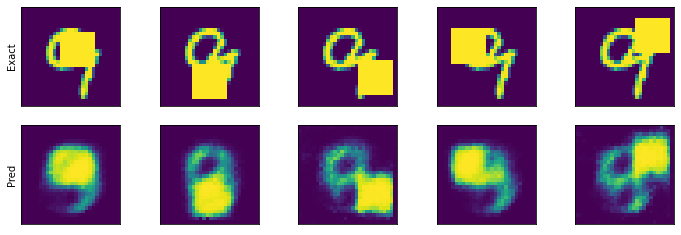

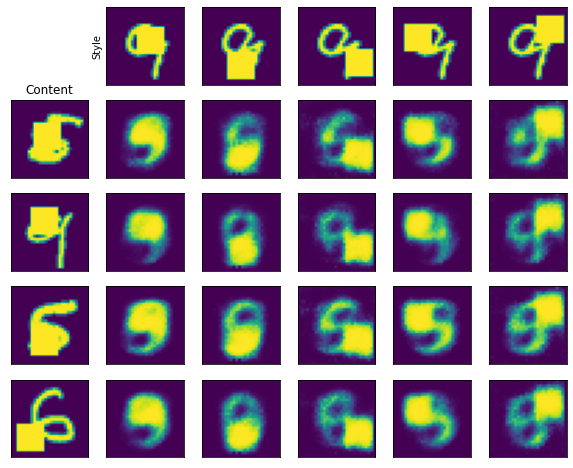

	mean loss    = 570.739
	mse          = 1.107e+03
	KL           = 1.734e+01
	dec_var      = 1.000e+00
epoch = 64.33s
Start of epoch 1
	mean loss    = 341.506
	mse          = 6.408e+02
	KL           = 2.113e+01
	dec_var      = 1.000e+00
epoch = 45.72s
Start of epoch 2
	mean loss    = 298.488
	mse          = 5.495e+02
	KL           = 2.373e+01
	dec_var      = 1.000e+00
epoch = 43.82s
Start of epoch 3
	mean loss    = 274.776
	mse          = 4.980e+02
	KL           = 2.579e+01
	dec_var      = 1.000e+00
epoch = 43.84s
Start of epoch 4
	mean loss    = 258.737
	mse          = 4.633e+02
	KL           = 2.710e+01
	dec_var      = 1.000e+00
epoch = 43.59s
Start of epoch 5
=== TRN ===


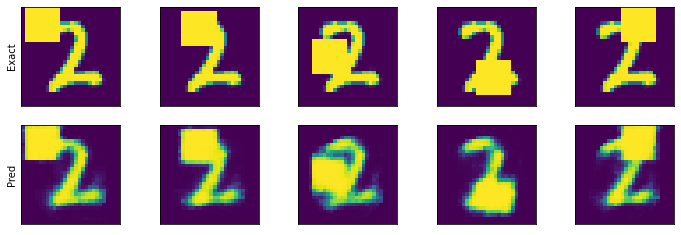

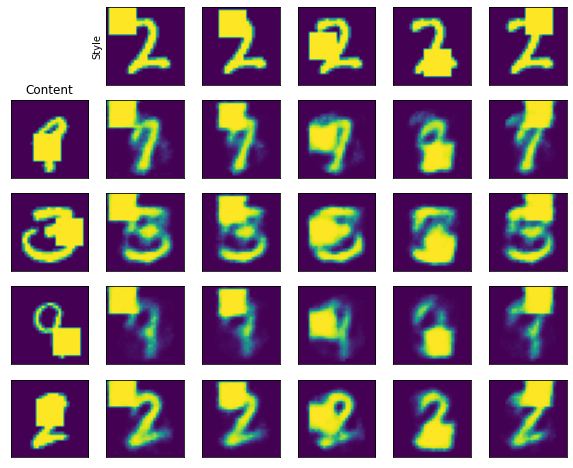

	mean loss    = 247.794
	mse          = 4.399e+02
	KL           = 2.783e+01
	dec_var      = 1.000e+00
epoch = 46.32s
Start of epoch 6
	mean loss    = 239.071
	mse          = 4.213e+02
	KL           = 2.841e+01
	dec_var      = 1.000e+00
epoch = 44.47s
Start of epoch 7
	mean loss    = 231.693
	mse          = 4.055e+02
	KL           = 2.894e+01
	dec_var      = 1.000e+00
epoch = 43.90s
Start of epoch 8
	mean loss    = 225.364
	mse          = 3.921e+02
	KL           = 2.929e+01
	dec_var      = 1.000e+00
epoch = 44.54s
Start of epoch 9
	mean loss    = 219.982
	mse          = 3.808e+02
	KL           = 2.957e+01
	dec_var      = 1.000e+00
epoch = 43.79s
Start of epoch 10
=== TRN ===


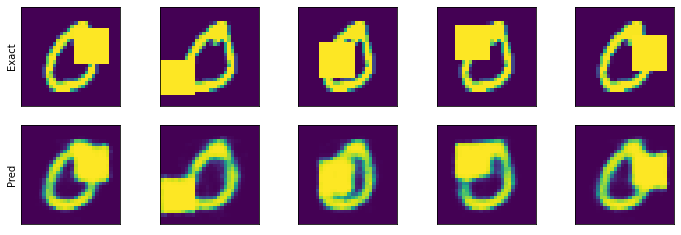

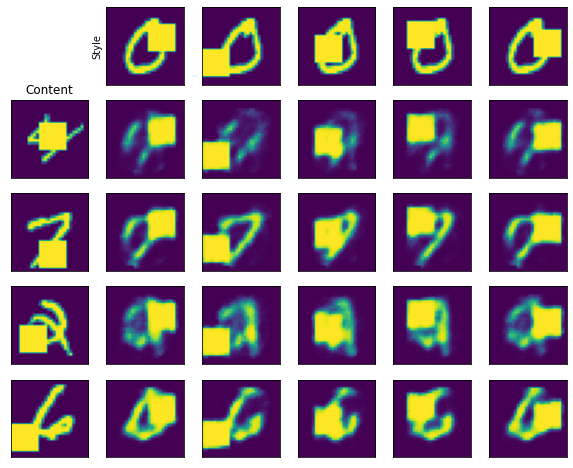

	mean loss    = 215.161
	mse          = 3.707e+02
	KL           = 2.980e+01
	dec_var      = 1.000e+00
epoch = 46.25s
Start of epoch 11
	mean loss    = 210.881
	mse          = 3.618e+02
	KL           = 3.000e+01
	dec_var      = 1.000e+00
epoch = 44.40s
Start of epoch 12
	mean loss    = 206.705
	mse          = 3.530e+02
	KL           = 3.022e+01
	dec_var      = 1.000e+00
epoch = 44.75s
Start of epoch 13
	mean loss    = 202.937
	mse          = 3.449e+02
	KL           = 3.048e+01
	dec_var      = 1.000e+00
epoch = 43.97s
Start of epoch 14
	mean loss    = 199.531
	mse          = 3.377e+02
	KL           = 3.067e+01
	dec_var      = 1.000e+00
epoch = 44.63s
Start of epoch 15
=== TRN ===


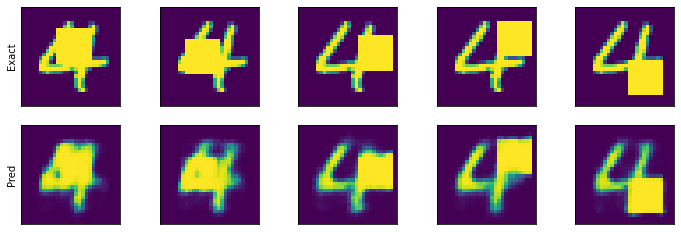

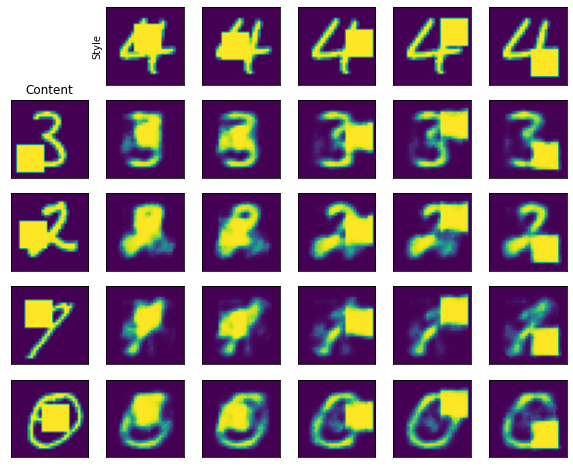

	mean loss    = 196.463
	mse          = 3.312e+02
	KL           = 3.084e+01
	dec_var      = 1.000e+00
epoch = 46.39s
Start of epoch 16
	mean loss    = 193.682
	mse          = 3.254e+02
	KL           = 3.097e+01
	dec_var      = 1.000e+00
epoch = 45.42s
Start of epoch 17
	mean loss    = 191.018
	mse          = 3.198e+02
	KL           = 3.111e+01
	dec_var      = 1.000e+00
epoch = 44.16s
Start of epoch 18
	mean loss    = 188.678
	mse          = 3.149e+02
	KL           = 3.122e+01
	dec_var      = 1.000e+00
epoch = 44.88s
Start of epoch 19
	mean loss    = 186.537
	mse          = 3.104e+02
	KL           = 3.132e+01
	dec_var      = 1.000e+00
epoch = 44.39s
Start of epoch 20
=== TRN ===


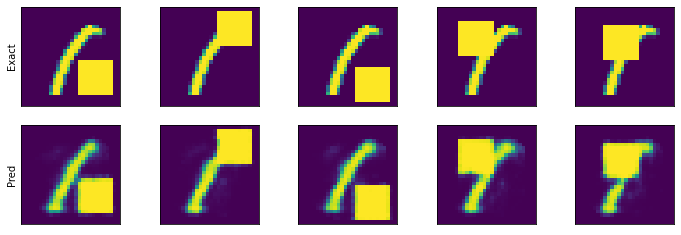

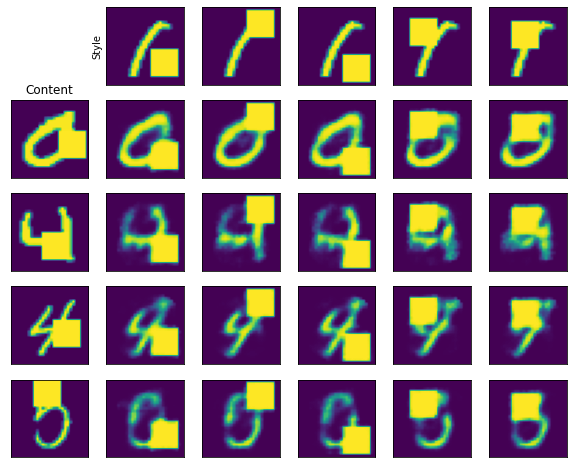

	mean loss    = 184.489
	mse          = 3.062e+02
	KL           = 3.141e+01
	dec_var      = 1.000e+00
epoch = 46.50s
Start of epoch 21
	mean loss    = 182.537
	mse          = 3.021e+02
	KL           = 3.150e+01
	dec_var      = 1.000e+00
epoch = 43.74s
Start of epoch 22
	mean loss    = 180.755
	mse          = 2.983e+02
	KL           = 3.160e+01
	dec_var      = 1.000e+00
epoch = 43.81s
Start of epoch 23
	mean loss    = 179.103
	mse          = 2.949e+02
	KL           = 3.166e+01
	dec_var      = 1.000e+00
epoch = 44.46s
Start of epoch 24
	mean loss    = 177.623
	mse          = 2.917e+02
	KL           = 3.175e+01
	dec_var      = 1.000e+00
epoch = 44.47s
Start of epoch 25
=== TRN ===


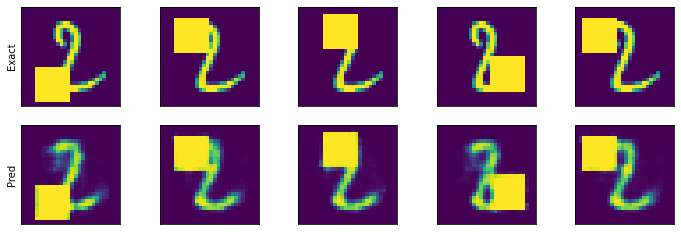

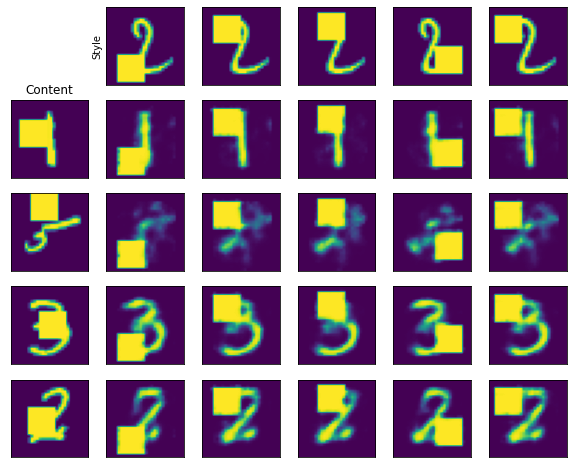

	mean loss    = 176.069
	mse          = 2.885e+02
	KL           = 3.183e+01
	dec_var      = 1.000e+00
epoch = 45.74s
Start of epoch 26
	mean loss    = 174.502
	mse          = 2.852e+02
	KL           = 3.192e+01
	dec_var      = 1.000e+00
epoch = 43.28s
Start of epoch 27
	mean loss    = 173.204
	mse          = 2.824e+02
	KL           = 3.202e+01
	dec_var      = 1.000e+00
epoch = 44.62s
Start of epoch 28
	mean loss    = 171.771
	mse          = 2.793e+02
	KL           = 3.211e+01
	dec_var      = 1.000e+00
epoch = 44.55s
Start of epoch 29
	mean loss    = 170.616
	mse          = 2.768e+02
	KL           = 3.221e+01
	dec_var      = 1.000e+00
epoch = 44.48s
Start of epoch 30
=== TRN ===


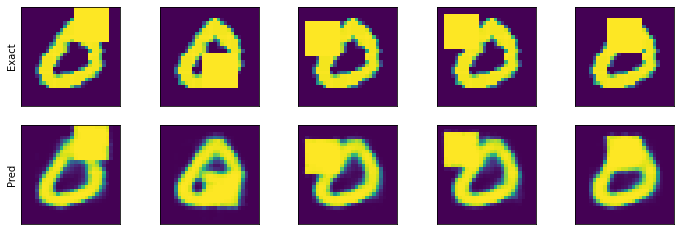

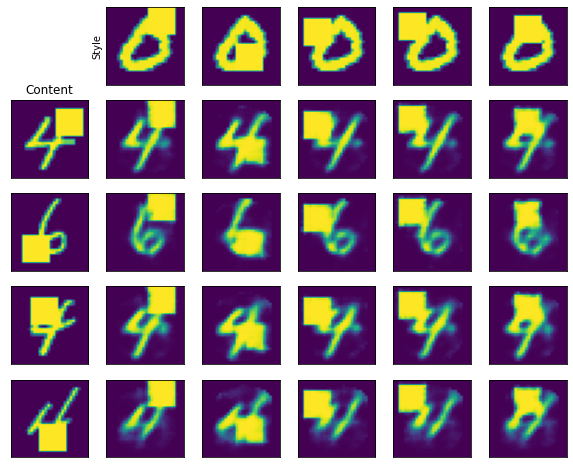

	mean loss    = 169.341
	mse          = 2.741e+02
	KL           = 3.227e+01
	dec_var      = 1.000e+00
epoch = 45.75s
Start of epoch 31
	mean loss    = 168.391
	mse          = 2.721e+02
	KL           = 3.235e+01
	dec_var      = 1.000e+00
epoch = 42.46s
Start of epoch 32
	mean loss    = 167.368
	mse          = 2.699e+02
	KL           = 3.241e+01
	dec_var      = 1.000e+00
epoch = 45.83s
Start of epoch 33
	mean loss    = 166.430
	mse          = 2.679e+02
	KL           = 3.246e+01
	dec_var      = 1.000e+00
epoch = 44.57s
Start of epoch 34
	mean loss    = 165.352
	mse          = 2.657e+02
	KL           = 3.252e+01
	dec_var      = 1.000e+00
epoch = 45.71s
Start of epoch 35
=== TRN ===


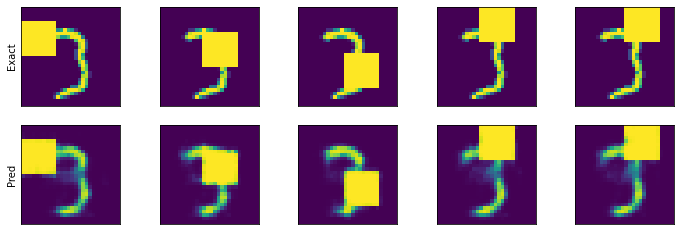

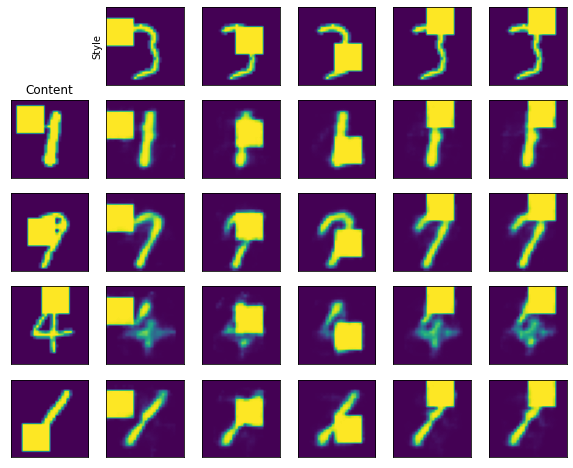

	mean loss    = 164.645
	mse          = 2.642e+02
	KL           = 3.255e+01
	dec_var      = 1.000e+00
epoch = 47.44s
Start of epoch 36
	mean loss    = 163.727
	mse          = 2.622e+02
	KL           = 3.261e+01
	dec_var      = 1.000e+00
epoch = 46.02s
Start of epoch 37
	mean loss    = 162.980
	mse          = 2.606e+02
	KL           = 3.267e+01
	dec_var      = 1.000e+00
epoch = 45.10s
Start of epoch 38
	mean loss    = 162.113
	mse          = 2.588e+02
	KL           = 3.269e+01
	dec_var      = 1.000e+00
epoch = 45.84s
Start of epoch 39
	mean loss    = 161.438
	mse          = 2.574e+02
	KL           = 3.274e+01
	dec_var      = 1.000e+00
epoch = 45.91s
Start of epoch 40
=== TRN ===


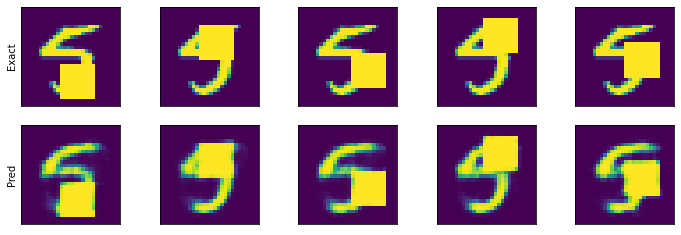

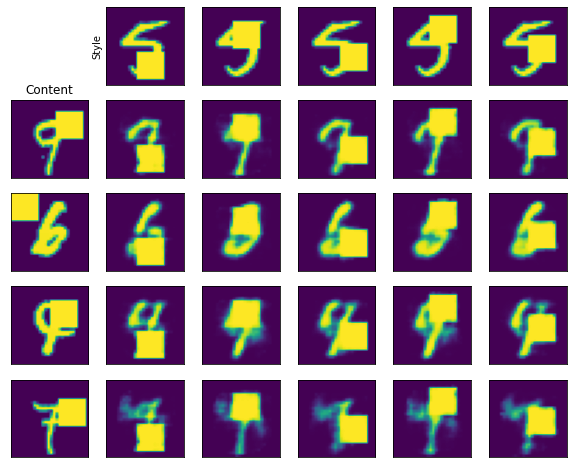

	mean loss    = 160.698
	mse          = 2.559e+02
	KL           = 3.276e+01
	dec_var      = 1.000e+00
epoch = 45.13s
Start of epoch 41
	mean loss    = 160.171
	mse          = 2.547e+02
	KL           = 3.281e+01
	dec_var      = 1.000e+00
epoch = 46.36s
Start of epoch 42
	mean loss    = 159.376
	mse          = 2.531e+02
	KL           = 3.283e+01
	dec_var      = 1.000e+00
epoch = 45.99s
Start of epoch 43
	mean loss    = 158.839
	mse          = 2.520e+02
	KL           = 3.286e+01
	dec_var      = 1.000e+00
epoch = 44.91s
Start of epoch 44
	mean loss    = 158.219
	mse          = 2.507e+02
	KL           = 3.289e+01
	dec_var      = 1.000e+00
epoch = 45.90s
Start of epoch 45
=== TRN ===


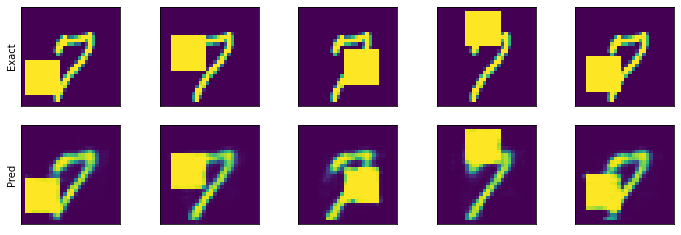

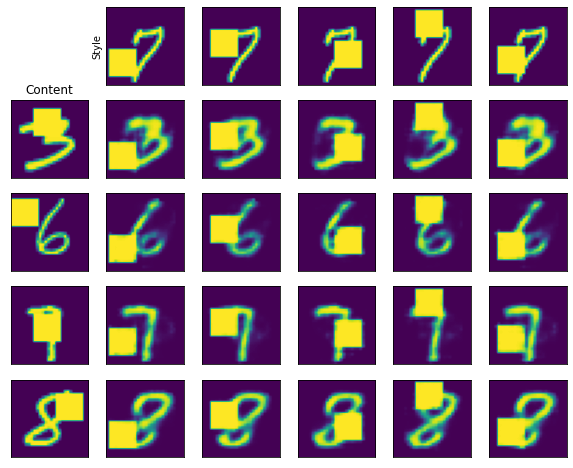

	mean loss    = 157.668
	mse          = 2.495e+02
	KL           = 3.292e+01
	dec_var      = 1.000e+00
epoch = 47.35s
Start of epoch 46
	mean loss    = 157.121
	mse          = 2.483e+02
	KL           = 3.295e+01
	dec_var      = 1.000e+00
epoch = 46.30s
Start of epoch 47
	mean loss    = 156.528
	mse          = 2.471e+02
	KL           = 3.298e+01
	dec_var      = 1.000e+00
epoch = 43.64s
Start of epoch 48
	mean loss    = 156.105
	mse          = 2.462e+02
	KL           = 3.300e+01
	dec_var      = 1.000e+00
epoch = 45.24s
Start of epoch 49
	mean loss    = 155.570
	mse          = 2.451e+02
	KL           = 3.302e+01
	dec_var      = 1.000e+00
epoch = 44.67s
Start of epoch 50
=== TRN ===


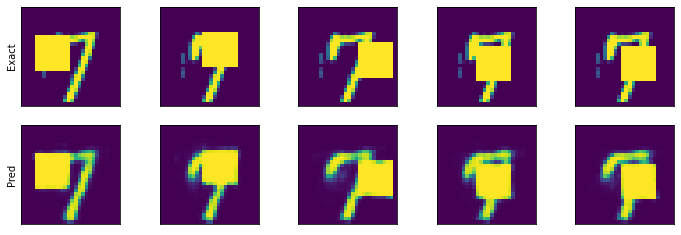

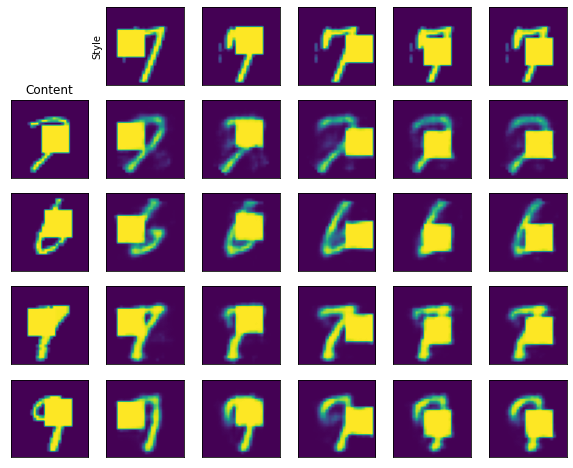

	mean loss    = 155.128
	mse          = 2.442e+02
	KL           = 3.304e+01
	dec_var      = 1.000e+00
epoch = 48.09s
Start of epoch 51
	mean loss    = 154.707
	mse          = 2.433e+02
	KL           = 3.306e+01
	dec_var      = 1.000e+00
epoch = 45.28s
Start of epoch 52
	mean loss    = 154.214
	mse          = 2.423e+02
	KL           = 3.309e+01
	dec_var      = 1.000e+00
epoch = 44.87s
Start of epoch 53
	mean loss    = 153.874
	mse          = 2.415e+02
	KL           = 3.310e+01
	dec_var      = 1.000e+00
epoch = 45.73s
Start of epoch 54
	mean loss    = 153.426
	mse          = 2.406e+02
	KL           = 3.312e+01
	dec_var      = 1.000e+00
epoch = 44.67s
Start of epoch 55
=== TRN ===


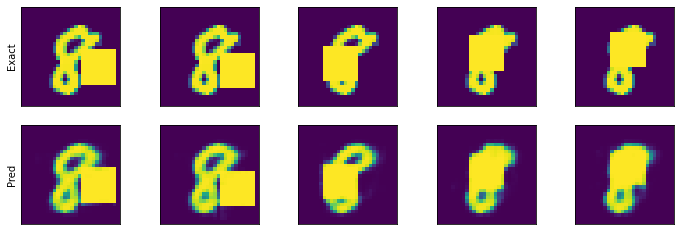

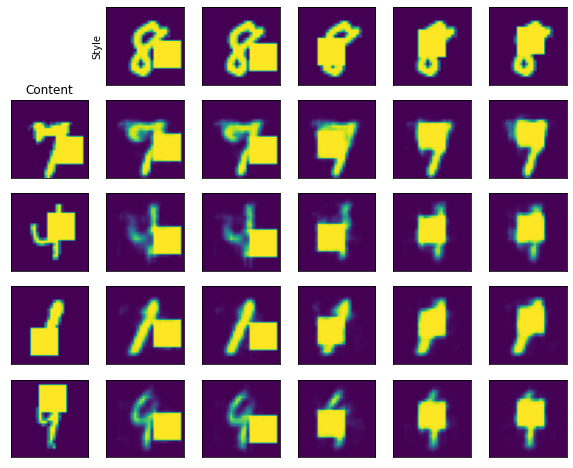

	mean loss    = 152.989
	mse          = 2.397e+02
	KL           = 3.313e+01
	dec_var      = 1.000e+00
epoch = 46.79s
Start of epoch 56
	mean loss    = 152.583
	mse          = 2.389e+02
	KL           = 3.316e+01
	dec_var      = 1.000e+00
epoch = 45.89s
Start of epoch 57
	mean loss    = 152.337
	mse          = 2.383e+02
	KL           = 3.317e+01
	dec_var      = 1.000e+00
epoch = 45.66s
Start of epoch 58
	mean loss    = 151.996
	mse          = 2.376e+02
	KL           = 3.320e+01
	dec_var      = 1.000e+00
epoch = 45.33s
Start of epoch 59
	mean loss    = 151.481
	mse          = 2.366e+02
	KL           = 3.320e+01
	dec_var      = 1.000e+00
epoch = 44.34s
Start of epoch 60
=== TRN ===


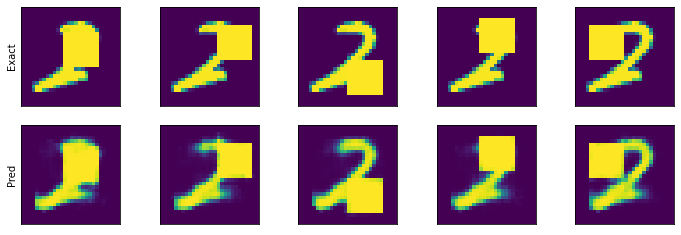

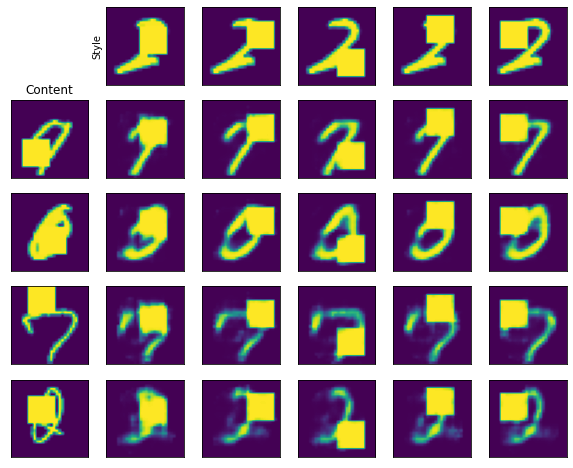

	mean loss    = 151.005
	mse          = 2.356e+02
	KL           = 3.321e+01
	dec_var      = 1.000e+00
epoch = 47.76s
Start of epoch 61
	mean loss    = 150.695
	mse          = 2.349e+02
	KL           = 3.323e+01
	dec_var      = 1.000e+00
epoch = 48.27s
Start of epoch 62
	mean loss    = 150.476
	mse          = 2.345e+02
	KL           = 3.325e+01
	dec_var      = 1.000e+00
epoch = 48.46s
Start of epoch 63
	mean loss    = 150.138
	mse          = 2.338e+02
	KL           = 3.325e+01
	dec_var      = 1.000e+00
epoch = 46.33s
Start of epoch 64
	mean loss    = 149.856
	mse          = 2.332e+02
	KL           = 3.327e+01
	dec_var      = 1.000e+00
epoch = 48.17s
Start of epoch 65
=== TRN ===


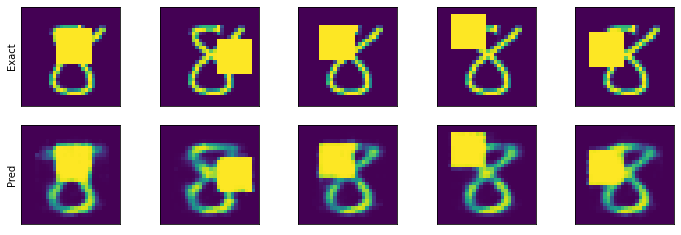

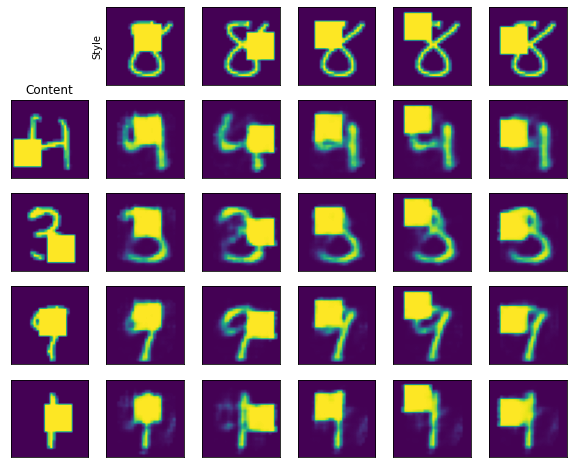

	mean loss    = 149.513
	mse          = 2.325e+02
	KL           = 3.328e+01
	dec_var      = 1.000e+00
epoch = 50.86s
Start of epoch 66
	mean loss    = 149.240
	mse          = 2.319e+02
	KL           = 3.329e+01
	dec_var      = 1.000e+00
epoch = 48.44s
Start of epoch 67
	mean loss    = 148.926
	mse          = 2.313e+02
	KL           = 3.329e+01
	dec_var      = 1.000e+00
epoch = 48.44s
Start of epoch 68
	mean loss    = 148.662
	mse          = 2.307e+02
	KL           = 3.331e+01
	dec_var      = 1.000e+00
epoch = 49.84s
Start of epoch 69
	mean loss    = 148.542
	mse          = 2.304e+02
	KL           = 3.332e+01
	dec_var      = 1.000e+00
epoch = 49.17s
Start of epoch 70
=== TRN ===


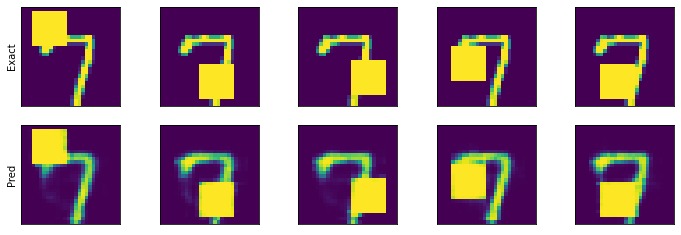

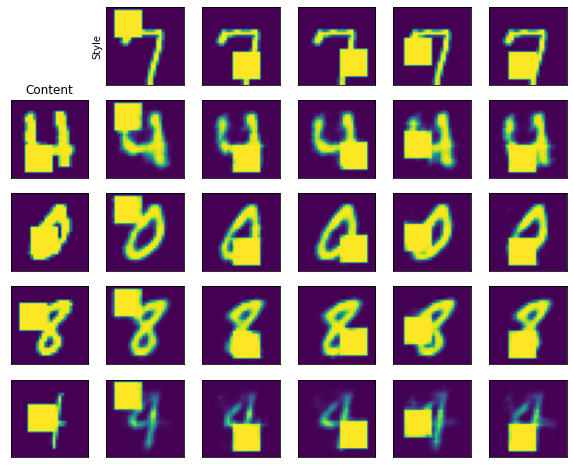

	mean loss    = 148.157
	mse          = 2.297e+02
	KL           = 3.332e+01
	dec_var      = 1.000e+00
epoch = 50.60s
Start of epoch 71
	mean loss    = 147.806
	mse          = 2.289e+02
	KL           = 3.334e+01
	dec_var      = 1.000e+00
epoch = 48.02s
Start of epoch 72
	mean loss    = 147.590
	mse          = 2.285e+02
	KL           = 3.334e+01
	dec_var      = 1.000e+00
epoch = 48.86s
Start of epoch 73
	mean loss    = 147.439
	mse          = 2.281e+02
	KL           = 3.337e+01
	dec_var      = 1.000e+00
epoch = 47.67s
Start of epoch 74
	mean loss    = 147.198
	mse          = 2.276e+02
	KL           = 3.338e+01
	dec_var      = 1.000e+00
epoch = 46.20s
Start of epoch 75
=== TRN ===


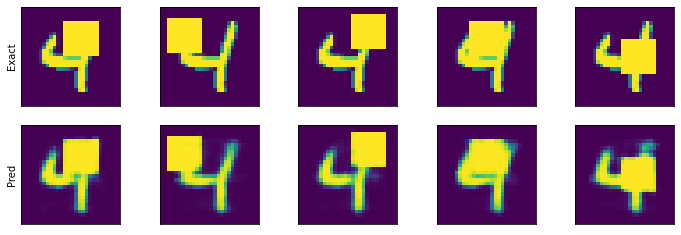

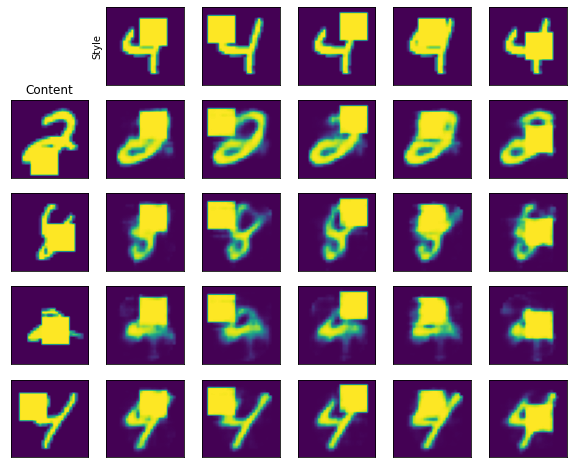

	mean loss    = 146.978
	mse          = 2.272e+02
	KL           = 3.337e+01
	dec_var      = 1.000e+00
epoch = 47.56s
Start of epoch 76
	mean loss    = 146.654
	mse          = 2.265e+02
	KL           = 3.339e+01
	dec_var      = 1.000e+00
epoch = 45.25s
Start of epoch 77
	mean loss    = 146.485
	mse          = 2.262e+02
	KL           = 3.340e+01
	dec_var      = 1.000e+00
epoch = 49.06s
Start of epoch 78
	mean loss    = 146.192
	mse          = 2.256e+02
	KL           = 3.340e+01
	dec_var      = 1.000e+00
epoch = 49.17s
Start of epoch 79
	mean loss    = 146.045
	mse          = 2.253e+02
	KL           = 3.341e+01
	dec_var      = 1.000e+00
epoch = 46.92s
Start of epoch 80
=== TRN ===


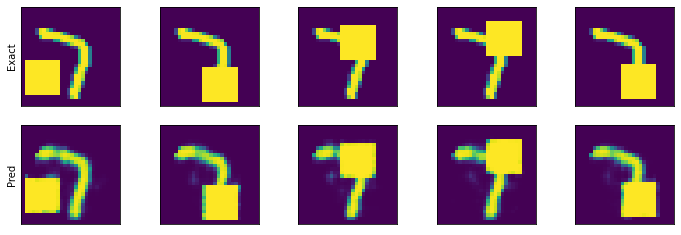

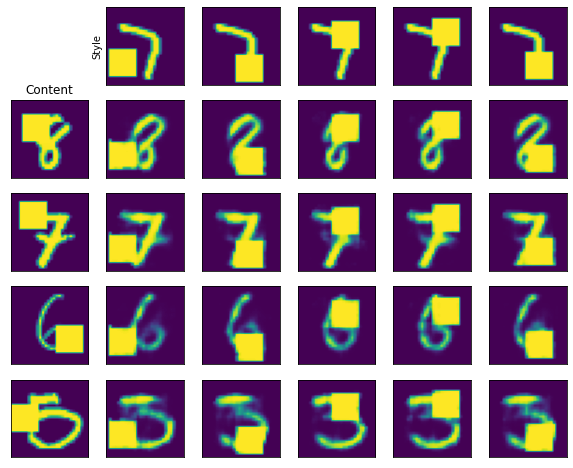

	mean loss    = 145.902
	mse          = 2.250e+02
	KL           = 3.342e+01
	dec_var      = 1.000e+00
epoch = 50.66s
Start of epoch 81
	mean loss    = 145.566
	mse          = 2.243e+02
	KL           = 3.343e+01
	dec_var      = 1.000e+00
epoch = 48.64s
Start of epoch 82
	mean loss    = 145.403
	mse          = 2.239e+02
	KL           = 3.344e+01
	dec_var      = 1.000e+00
epoch = 48.11s
Start of epoch 83
	mean loss    = 145.262
	mse          = 2.236e+02
	KL           = 3.344e+01
	dec_var      = 1.000e+00
epoch = 49.08s
Start of epoch 84
	mean loss    = 144.976
	mse          = 2.231e+02
	KL           = 3.343e+01
	dec_var      = 1.000e+00
epoch = 49.55s
Start of epoch 85
=== TRN ===


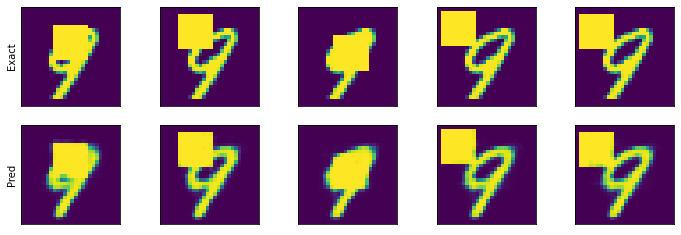

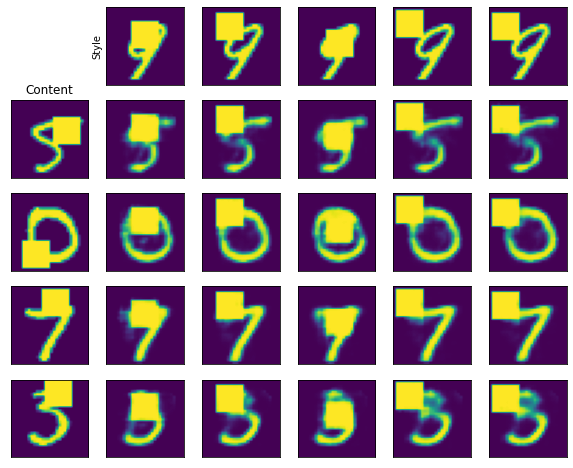

	mean loss    = 144.967
	mse          = 2.230e+02
	KL           = 3.345e+01
	dec_var      = 1.000e+00
epoch = 50.45s
Start of epoch 86
	mean loss    = 144.686
	mse          = 2.225e+02
	KL           = 3.345e+01
	dec_var      = 1.000e+00
epoch = 47.50s
Start of epoch 87
	mean loss    = 144.395
	mse          = 2.219e+02
	KL           = 3.347e+01
	dec_var      = 1.000e+00
epoch = 48.35s
Start of epoch 88
	mean loss    = 144.323
	mse          = 2.217e+02
	KL           = 3.347e+01
	dec_var      = 1.000e+00
epoch = 45.96s
Start of epoch 89
	mean loss    = 144.092
	mse          = 2.213e+02
	KL           = 3.346e+01
	dec_var      = 1.000e+00
epoch = 44.77s
Start of epoch 90
=== TRN ===


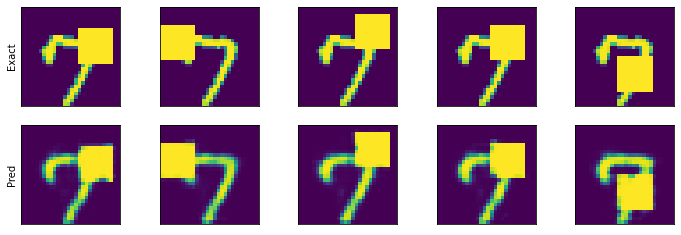

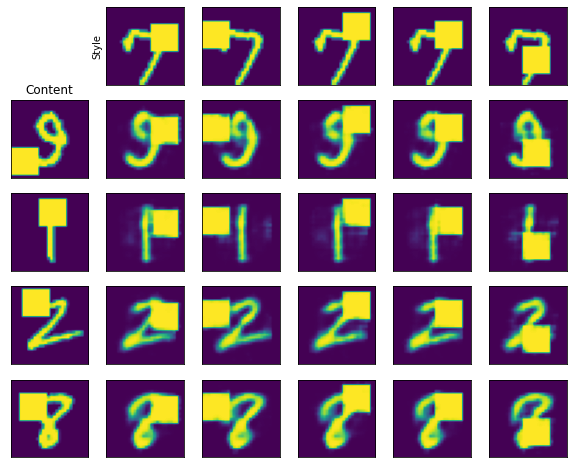

	mean loss    = 143.889
	mse          = 2.208e+02
	KL           = 3.348e+01
	dec_var      = 1.000e+00
epoch = 47.05s
Start of epoch 91
	mean loss    = 143.806
	mse          = 2.207e+02
	KL           = 3.348e+01
	dec_var      = 1.000e+00
epoch = 44.47s
Start of epoch 92
	mean loss    = 143.544
	mse          = 2.201e+02
	KL           = 3.348e+01
	dec_var      = 1.000e+00
epoch = 44.13s
Start of epoch 93
	mean loss    = 143.438
	mse          = 2.199e+02
	KL           = 3.349e+01
	dec_var      = 1.000e+00
epoch = 43.98s
Start of epoch 94
	mean loss    = 143.214
	mse          = 2.194e+02
	KL           = 3.349e+01
	dec_var      = 1.000e+00
epoch = 44.41s
Start of epoch 95
=== TRN ===


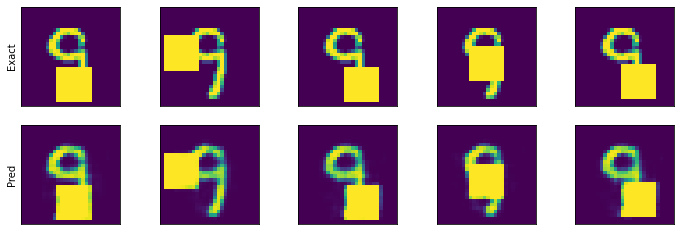

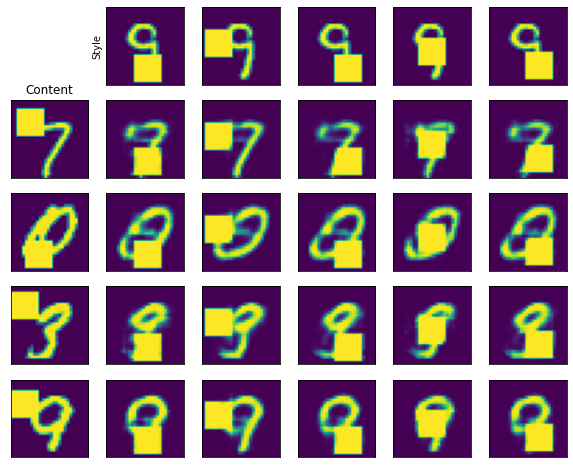

	mean loss    = 143.047
	mse          = 2.191e+02
	KL           = 3.350e+01
	dec_var      = 1.000e+00
epoch = 47.84s
Start of epoch 96
	mean loss    = 143.030
	mse          = 2.190e+02
	KL           = 3.351e+01
	dec_var      = 1.000e+00
epoch = 45.06s
Start of epoch 97
	mean loss    = 142.818
	mse          = 2.186e+02
	KL           = 3.353e+01
	dec_var      = 1.000e+00
epoch = 44.72s
Start of epoch 98
	mean loss    = 142.638
	mse          = 2.182e+02
	KL           = 3.351e+01
	dec_var      = 1.000e+00
epoch = 45.18s
Start of epoch 99
	mean loss    = 142.549
	mse          = 2.180e+02
	KL           = 3.353e+01
	dec_var      = 1.000e+00
epoch = 45.32s
Start of epoch 100
=== TRN ===


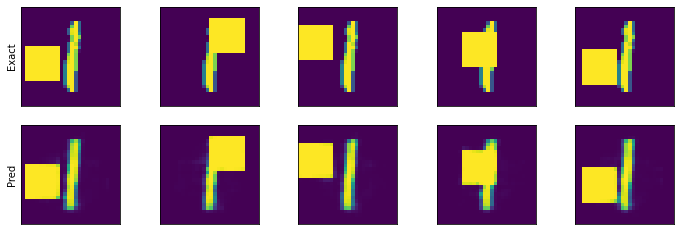

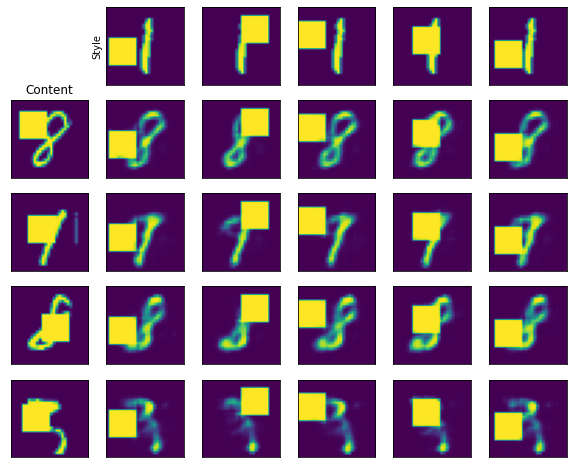

	mean loss    = 142.407
	mse          = 2.178e+02
	KL           = 3.353e+01
	dec_var      = 1.000e+00
epoch = 46.78s


In [7]:
# Iterate over epochs.
num_epochs = 101

for epoch in range(num_epochs):
#     display.clear_output(wait=False)
    print('===================', flush=True)
    print('Start of epoch %d' % (epoch,))
    start_time = time.perf_counter()
         
    for step, trn_batch in enumerate(trn_dist_dataset):
        _ = distributed_train_step(trn_batch)
            
    if epoch % 5 == 0:
        print('=== TRN ===')
#         if strategy.num_replicas_in_sync > 1:
#             # grab only batch assigned to first GPU
#             trn_batch = [x.values[0].numpy() for x in trn_batch]
#         else:
#             trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = trn_batch.numpy()

        trn_batch = trn_batch.values[0].numpy()
        """ plot decoding of replicates """
        pred = symvae.encode_decode(trn_batch)
#         se = (pred - trn_batch[0])**2 # squared error
        
        pred = pred.numpy()
        
        plt.figure(figsize=(12,4), facecolor='w')
        num_instance_plot = min([5, NUM_INSTANCES])
        for kk in np.arange(num_instance_plot):
            plt.subplot(2, num_instance_plot, kk+1)
            plt.imshow(trn_batch[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Exact')
                    
            plt.subplot(2, num_instance_plot, num_instance_plot+kk+1)
            plt.imshow(pred[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Pred')
            
        plt.show()
        
        """ plot styling of replicates """
        nsplot = 5 # number of style plots

        content_code = symvae.content_encode(trn_batch).numpy()
        style_code = symvae.style_encode(trn_batch).numpy()
        
        plt.figure(figsize=(10,10), facecolor='w')
        for jj in np.arange(nsplot):
            styled_mean = symvae.style_decode(content_code[[jj],:,:], style_code[[0],:,:])
            styled_mean = styled_mean.numpy()
            for kk in np.arange(nsplot):
                if jj == 0:
                    # plot the style of each instance inside the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, kk+2)
                    plt.imshow(trn_batch[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    if kk==0:
                        plt.ylabel('Style')
                else:
                    if kk==0:
                        # plot an instance to show the "content"
                        plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+1)
                        plt.imshow(trn_batch[jj,0,:].reshape(28,28))
                        plt.xticks([]); plt.yticks([]);
                        if jj == 1:
                            plt.title('Content')

                    # style the jth bag with styles from the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+2)
                    plt.imshow(styled_mean[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    
        plt.show()
    
    print('\tmean loss    = %.3f' % trn_loss_metric.result().numpy())
    print('\tmse          = %.3e' % trn_mse_metric.result().numpy())
#     print('\tKL           = %.3e' % trn_sty_KL_metric.result().numpy())
    print('\tKL           = %.3e' % trn_cnt_KL_metric.result().numpy())
    print('\tdec_var      = %.3e' % symvae.decoder.dec_var.numpy())
    trn_loss_metric.reset_states()
    trn_mse_metric.reset_states()
#     trn_sty_KL_metric.reset_states()
    trn_cnt_KL_metric.reset_states()
    
    print('epoch = %.2fs' % (time.perf_counter()-start_time))

In [9]:
# # https://www.tensorflow.org/guide/keras/save_and_serialize#hdf5_format
symvae.save_weights('partial-symvae-masked-mnist-p0_2.h5')

### Load

0


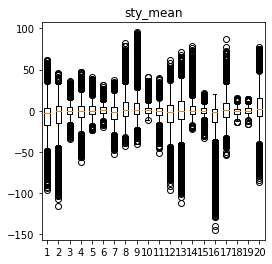

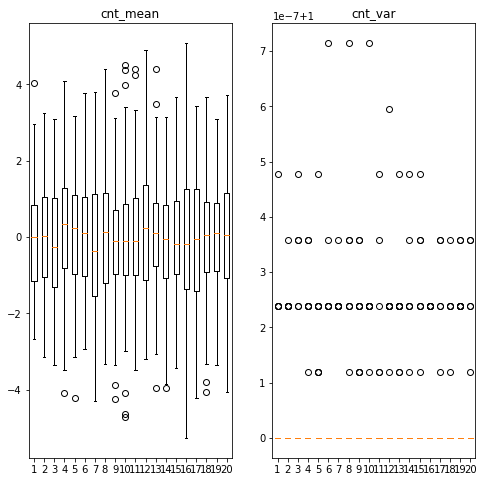

1


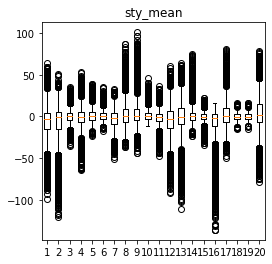

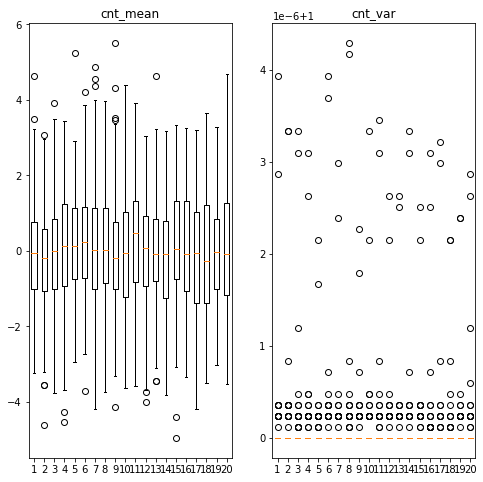

2


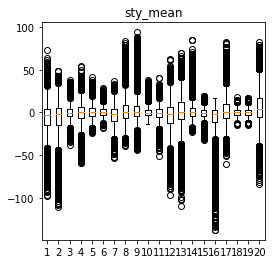

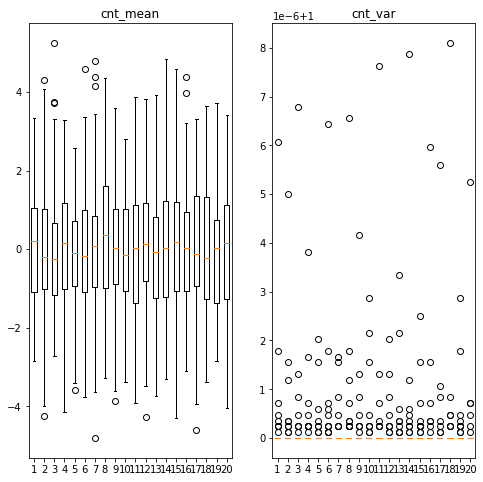

3


In [10]:
# check style variance and plot 
for kk, trn_batch in enumerate(trn_dataset):
    print(kk)
    if kk > 2:
        break
        
    """ compute style encoding """
    sty_mean = symvae.style_encoder(trn_batch)
    sty_mean = sty_mean.numpy()
    
    cnt_mean, cnt_log_var = symvae.content_encoder(trn_batch)
    
    plt.figure(figsize=(4,4))
    plt.boxplot(sty_mean.reshape(-1, 20))
    plt.title('sty_mean')
    plt.show()
    
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.boxplot(np.squeeze(cnt_mean))
    plt.title('cnt_mean')
    plt.subplot(122)
    plt.boxplot(np.exp(np.squeeze(cnt_log_var)))
    plt.title('cnt_var')
    plt.show()
    
#     print(type(sty_log_var))
#     print(sty_log_var.shape)    
